In [1]:
import pandas as pd
from datetime import datetime

dated = pd.read_csv('moonshot_dated_data.csv', index_col=0)
# https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes
for k in ('SUBMITTED_DATE','ORDERED_DATE','SHIPMENT_DATE'):
    dated[k.lower()] = pd.to_datetime(dated[k], format='%Y%m%d')

In [28]:
import re

def fix_ic50(value):
    if str(value) == 'nan':
        return 100
    if isinstance(value, float):
        return value
    rex = re.search('([\d.]+)', str(value))
    if rex:
        return float(rex.group(1))
    return 100

dated['IC50'] = dated['ProteaseAssay_Fluorescence_Dose-Response_Weizmann: Avg IC50 (uM)'].apply(fix_ic50)

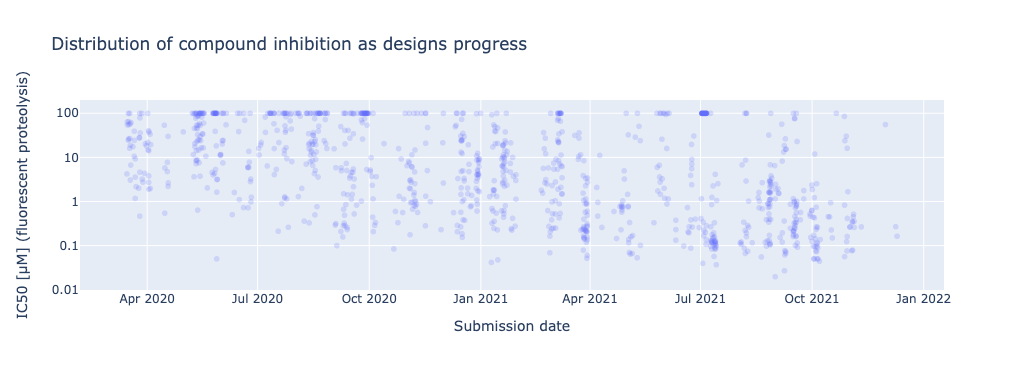

In [29]:
import random
import plotly.express as px

wobble = 48 # hours
dated['wobbled_submitted_date'] = dated.submitted_date.apply(lambda v: v + pd.Timedelta(seconds=60*60*random.uniform(-wobble, wobble)) )

fig = px.scatter(dated,
                   x='wobbled_submitted_date',
                   y='IC50',
                   title='Distribution of compound inhibition as designs progress',
                   log_y=True)
fig.update_traces(opacity=0.20)
fig.update_layout(xaxis=dict(title='Submission date'),
                  yaxis=dict(title='IC50 [µM] (fluorescent proteolysis)')
                 )
fig

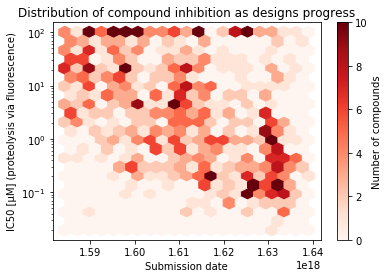

In [30]:

# < 0.0562
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

subbed = dated.loc[~dated['IC50'].isna()]

plt.title('Distribution of compound inhibition as designs progress')
plt.ylabel('IC50 [µM] (proteolysis via fluorescence)')
plt.xlabel('Submission date')
plt.hexbin(x=subbed.submitted_date.values.astype(datetime),
               y=subbed['IC50'].values,
               yscale='log',
               gridsize=20,
               #marginals=True,
               cmap='Reds',
               vmin=0, vmax=10
               )

cb = plt.colorbar()
cb.set_label('Number of compounds')

plt.show()

In [31]:
import pandas as pd
moonshot = pd.read_pickle('moonshot_submissions.p')

In [32]:
moonshot['IC50'] = moonshot['CID (canonical)'].map(dated.IC50)
moonshot['submission_date'] = moonshot['CID (canonical)'].map(dated.submitted_date)
moonshot['shipment_date'] = pd.to_datetime(moonshot.SHIPMENT_DATE, format='%Y-%m-%d')
moonshot['likely_submission_date'] = moonshot['submission_date'].fillna(method='bfill').fillna(method='ffill')

In [33]:
def is_nice(v):
    if isinstance(v, float):
        return str(v) != 'nan'
    if isinstance(v, str):
        return v.lower() not in ('', 'x0072', 'nan')
    return bool(v)
      
df = moonshot.loc[moonshot.SHIPMENT_DATE.astype(str) != '']
    
fullness = {}
for c in moonshot.columns:
    fullness[c] = sum(df[c].apply(is_nice))/len(df)
    
for k in sorted(fullness, key=lambda k: -fullness[k]):
    print(f'{k} {fullness[k]:.0%} {df[k].dtype.name}')

SMILES 100% object
CID 100% object
CID (canonical) 100% object
Postera Link 100% object
InChIKey 100% object
CDD_name 100% object
CDD_mol_ID 100% float64
ORDERED 100% bool
MADE 100% bool
SHIPMENT_DATE 100% object
CID_group 100% object
words 100% object
submission_date 100% datetime64[ns]
shipment_date 100% datetime64[ns]
likely_submission_date 100% datetime64[ns]
MW 100% float64
cLogP 100% float64
TPSA 100% float64
Rotatable Bonds 100% float64
Fraction sp3 100% float64
HBA 100% float64
HBD 100% float64
creator 88% object
rationale 88% object
Enamine - REAL Space 84% object
Enamine - Extended REAL Space 84% object
Enamine - SCR 84% object
Enamine - BB 84% object
Shipment Date 80% object
ASSAYED 68% bool
series 63% object
f_curve_IC50_y.1.1.1 62% object
f_max_inhibition_reading_y.1.1.1 62% object
f_min_inhibition_reading_y.1.1.1 62% object
f_hill_slope_y.1.1.1 62% object
f_R2_y.1.1.1 62% object
f_concentration_uM_y.1.1.1 62% object
f_inhibition_list_y.1.1.1 62% object
f_curve_IC50_x.1.1.

In [34]:
d = set(dated.index.values)
m = set(moonshot['CID (canonical)'].values)
dict(total=len(d.union(m)), 
     common=len(d.intersection(m)), 
     unique_to_dated=len(d.difference(m)), 
     unique_to_github=len(m.difference(d))
    )
#dated.index.to_seriess().map()

{'total': 20009,
 'common': 1048,
 'unique_to_dated': 0,
 'unique_to_github': 18961}

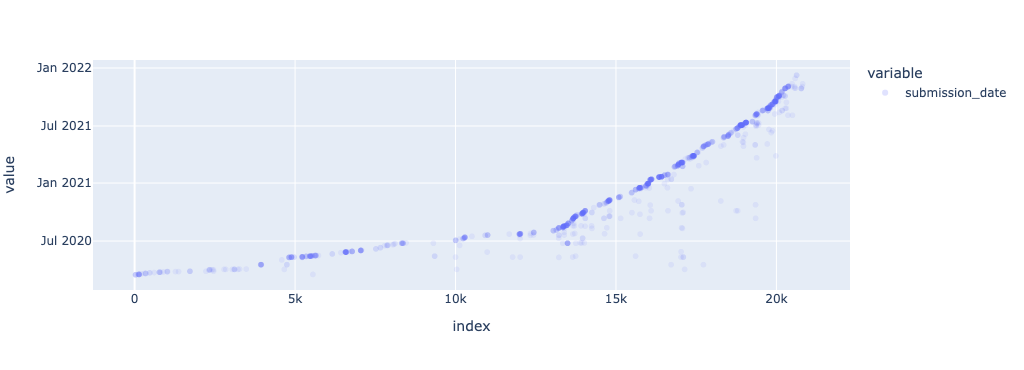

In [35]:
px.scatter(moonshot['submission_date'], opacity=0.1)

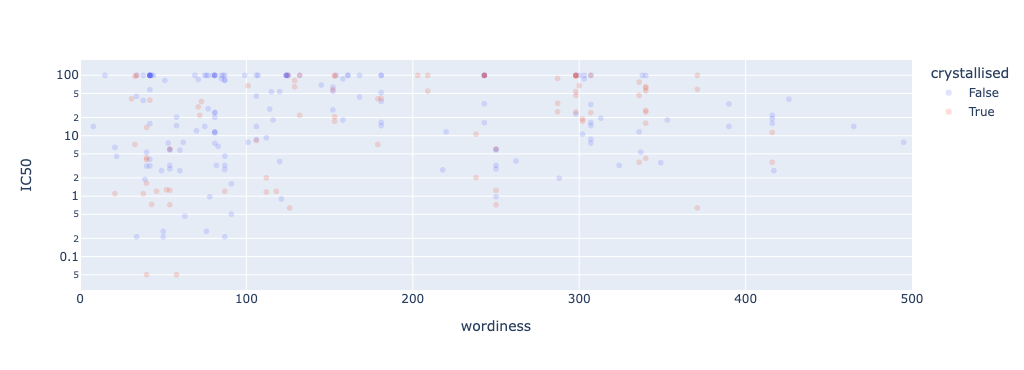

In [36]:
import plotly.express as px

moonshot['wordiness'] = moonshot.words.apply(len)
moonshot['crystallised'] = moonshot['Structure ID'] != ''

fig = px.scatter(moonshot.loc[moonshot['likely_submission_date'] < datetime(2020, 8, 1)],
          x='wordiness', y='IC50',
           log_y=True,
          color='crystallised',
          opacity=0.2)
fig.update_xaxes(range=[0, 500])
fig

In [37]:
moonshot['cutoff_wordiness'] = moonshot.wordiness.apply(lambda v: v if v < 500 else float('nan'))

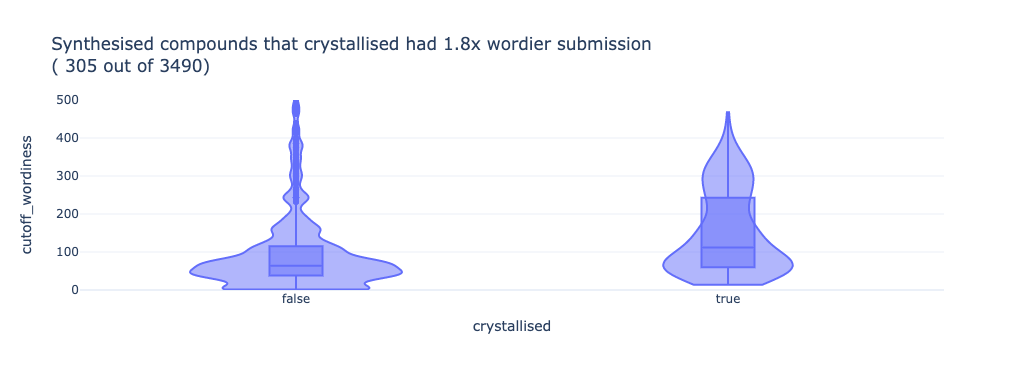

In [44]:
import plotly.express as px

subbed = moonshot.loc[moonshot.MADE]
md_no = subbed.loc[~subbed.crystallised].cutoff_wordiness.median()
md_yes = subbed.loc[subbed.crystallised].cutoff_wordiness.median()
fig = px.violin(subbed,
                y='cutoff_wordiness',
          x='crystallised',
            #log_y=True,
          template="plotly_white",
          title=f'Synthesised compounds that crystallised had {md_yes/md_no:.1f}x wordier submission<br>'
                f'( {len(subbed.loc[subbed.crystallised])} out of {len(subbed)})',
          box=True)
fig.update_traces(spanmode = 'hard')
fig.update_yaxes(range=[0, 500])
fig.show()

In [42]:
md_no, md_yes

(152.5, 153.0)

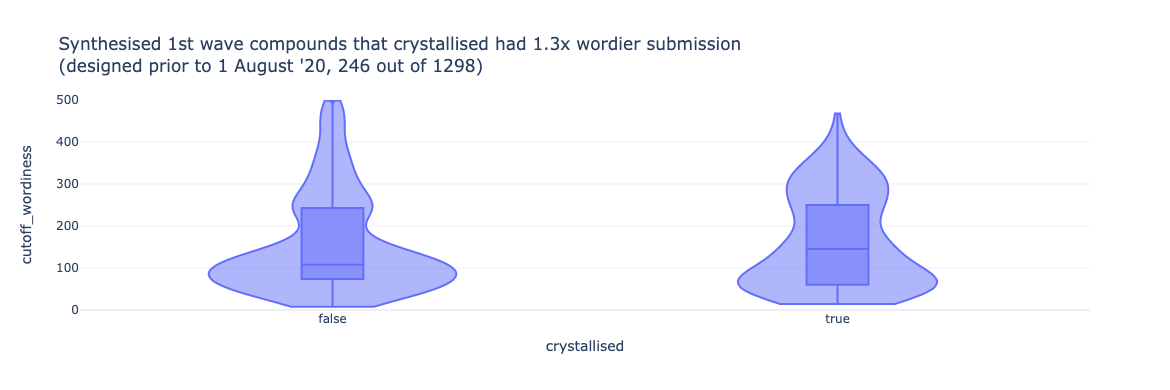

In [46]:
import plotly.express as px

subbed = moonshot.loc[moonshot.MADE & (moonshot['likely_submission_date'] < datetime(2020, 8, 1))]
md_no = subbed.loc[~subbed.crystallised].cutoff_wordiness.median()
md_yes = subbed.loc[subbed.crystallised].cutoff_wordiness.median()
fig = px.violin(subbed,
                y='cutoff_wordiness',
          x='crystallised',
            #log_y=True,
          template="plotly_white",
          title=f'Synthesised 1st wave compounds that crystallised had {md_yes/md_no:.1f}x wordier submission<br>'
                f'(designed prior to 1 August \'20, {len(subbed.loc[subbed.crystallised])} out of {len(subbed)})',
          box=True)
fig.update_traces(spanmode = 'hard')
fig.update_yaxes(range=[0, 500])
fig.show()

In [27]:
subbed.sort_values('wordiness', ascending=False)[['CID (canonical)', 'words', 'wordiness']]

,CID (canonical),words,wordiness
1845,VIJ-CYC-1a381570-13,we wanted to be informed by the set of fragmen...,3677
1837,VIJ-CYC-1a381570-5,we wanted to be informed by the set of fragmen...,3677
1844,VIJ-CYC-1a381570-12,we wanted to be informed by the set of fragmen...,3677
1843,VIJ-CYC-1a381570-11,we wanted to be informed by the set of fragmen...,3677
1842,VIJ-CYC-1a381570-10,we wanted to be informed by the set of fragmen...,3677
...,...,...,...
10128,ERI-UCB-ce40166b-17,merging the actives.,21
1248,PET-SGC-2e937068-1,0107/0426 combo,16
10297,WIL-UNI-2e73223c-4,siamese gcnns.,15
1124,PET-SGC-a8a902d9-1,107/387 combo,14
